# Red Wine Quality Analysis

The quality of red wine depends on how pleased professional wine tasters are. The chemical composition of red wine is also crucial for quality certification and assessment. This is done through physicochemical tests, which are conducted in laboratories and evaluate acidity, pH levels, sugars, and other chemical properties.

The objective of this project is to determine what elements of wine quality are the best indicators, and get insights into how they contribute to our model's red wine quality.

**Additional Objectives completed:**
- Draw loss curve (comparison between training loss and validation loss) for Keras model
- Use k-fold cross-validation for a accurate representation of model accuracy
- Being able to run inference as part of the notebook
- Use scikit-learn pipeline: Note - Used for keras regressor
- Identify overfitting or underfitting
- Identify and overcome data leakage
- Follow and test for pep8 standards (as much as possible)
- Break notebook in intelligible sections and put comments where necessary

**NOTE: The data can be accessed [here](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)**

## Importing the necessary libraries

In [75]:
import numpy as np
import pandas as pd

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for data preprocessing and splitting the data into training and testing datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer

#for building, tuning and evalutaing machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#for feature selection 
from sklearn.feature_selection import SelectFromModel

# ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

#! pip install xgboost
import xgboost
from xgboost import plot_importance
from matplotlib import pyplot

#For Neural Network
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from numpy.random import seed
#### Keras Regressor
from keras.wrappers.scikit_learn import KerasRegressor


## Reading the Data

- The dataset has **1,599 rows/observations** and **12 columns/features**
- All of the 12 columns are quantitative in nature
- The feature `quality` is the target feature, representing the quality of wine

The column descriptions are as follows:
- **Alcohol:** Amount of alcohol in wine
- **Volatile acidity:** High acetic acid in wine which leads to an unpleasant vinegar taste
- **Sulphates:** A wine additive that contributes to SO2 levels and acts as an antimicrobial and antioxidant
- **Citric Acid:** Acts as a preservative to increase acidity (small quantities add freshness and flavor to wines)
- **Total Sulfur Dioxide:** The amount of free + bound forms of SO2
- **Density:** Sweeter wines have a higher density
- **Chlorides:** The amount of salt in the wine
- **Fixed acidity:** Most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
- **pH:** The level of acidity
- **Free Sulfur Dioxide:** Prevents microbial growth and the oxidation of wine
- **Residual Sugar**: The amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter 
- **Quality**: A number indicating quality of the wine

Since the target variable is a quantitative variable, a regression approach can be taken for modelling this problem.

In [76]:
# Reading the data and storing in dataframe
wine = pd.read_csv('wine.csv')

# Print out the data for further information
print(wine.shape)
print(wine.columns)
wine.head()

(1599, 12)
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Exploratory Data Analysis

### Summary Statistics
- The maximum and minimum values of the features are not on the same scale. The fixed acidity varies from 4 to 16, where as free sulphur dioxide values can range from 1 to 72. 
- Data Standardization can be implemented going further for algorithms that expect a Gaussian distribution. Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1. This can be thought of as centering the data.
- we can see that the residual sugar has a huge outlier from the max of 15.5 which is quite far from the mean of 2.5 with a median (50%) of 2.2. These differences can also be seen in the free_sulfur_dioxide , total_sulfur_dioxide, sulphates, alcohol. 
- The pH values of wines lie between 3 and 4. This seems to be correct.

In [77]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### Checking data distribution per class/value of target variable

There is a class imbalance as 5,6 and 7 quality of wines form the maximum chunk of the dataset. Also, we only have data about the wine quality index of 3,4,5,6,7 and 8.

In [78]:
wine.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

### Checking Missing Data
There is no missing data in the dataset

In [79]:
wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Correlation Analysis

None of the features are strongly correlated with the wine quality. 
The columns `alcohol` and `volatile acidity` have a fair amount of correlation. As volatile acidity increases, wine quality seems to decrease where as the quality is postively correlated with alcohol content. This makes sense since higher volatile acidity leads to unpleasent taste.


In [80]:
correlations = wine.corr()['quality'].drop('quality')
print(correlations)

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64


- Fixed Acidity is postively correlated with density and citric acid content in the wine, while it is negatively correlated with pH (since higher the pH, more basic the chemical composition)
- Volatile Acidity is negatively correlated with cirtic acid
- Free and total sulphur dioxide have a positive correlation of 64%

Since the highest strength of correlation in this problem is just around 68%, I am not going to experiment by dropping any columns solely based on this result.

<AxesSubplot:>

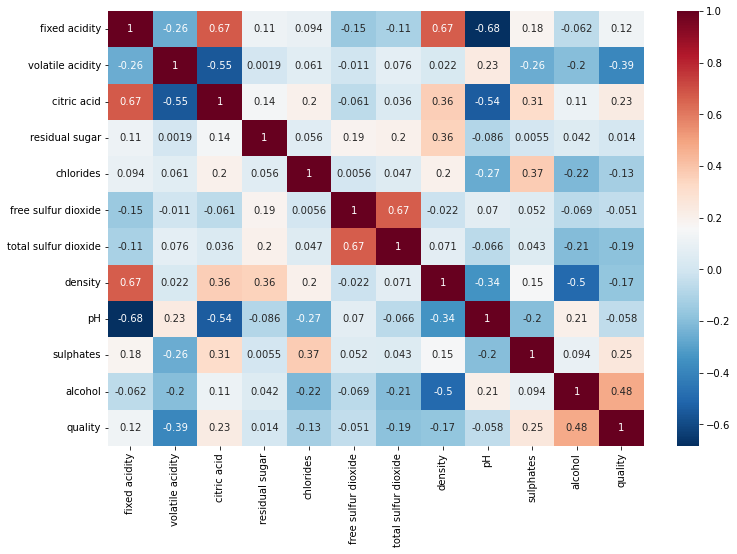

In [81]:
plt.figure(figsize=(12,8))
sns.heatmap(wine.corr(), annot=True, cmap = 'RdBu_r')

### Duplicate data

240 observations out of 1599 are duplicates. However, they do not seem to be errors. Since the data was recorded by testing wine samples, it is highly likely that the values for features might repeat. 

In [82]:
wine.duplicated().sum()

240

In [83]:
wine[wine.duplicated()].quality.value_counts()

5    104
6    103
7     32
8      1
Name: quality, dtype: int64

In [84]:
wine_no_duplicates = wine[~wine.duplicated()]

In [85]:
wine_no_duplicates.quality.value_counts()

5    577
6    535
7    167
4     53
8     17
3     10
Name: quality, dtype: int64

Most of the repeated data comes from wine quality 5 and 6. These also have high number of observations in the dataset. Dropping these datapoints can actually reduce class imbalance a bit. However, since the total datapoints avalibale are less, it is better to try the model performance with and without dropping these datapoints before coming to further conclusion. 

### Outlier Analysis

Outliers are the points outside the 1.5×IQR or more above the third quartile or 1.5×IQR or more below the first quartile.

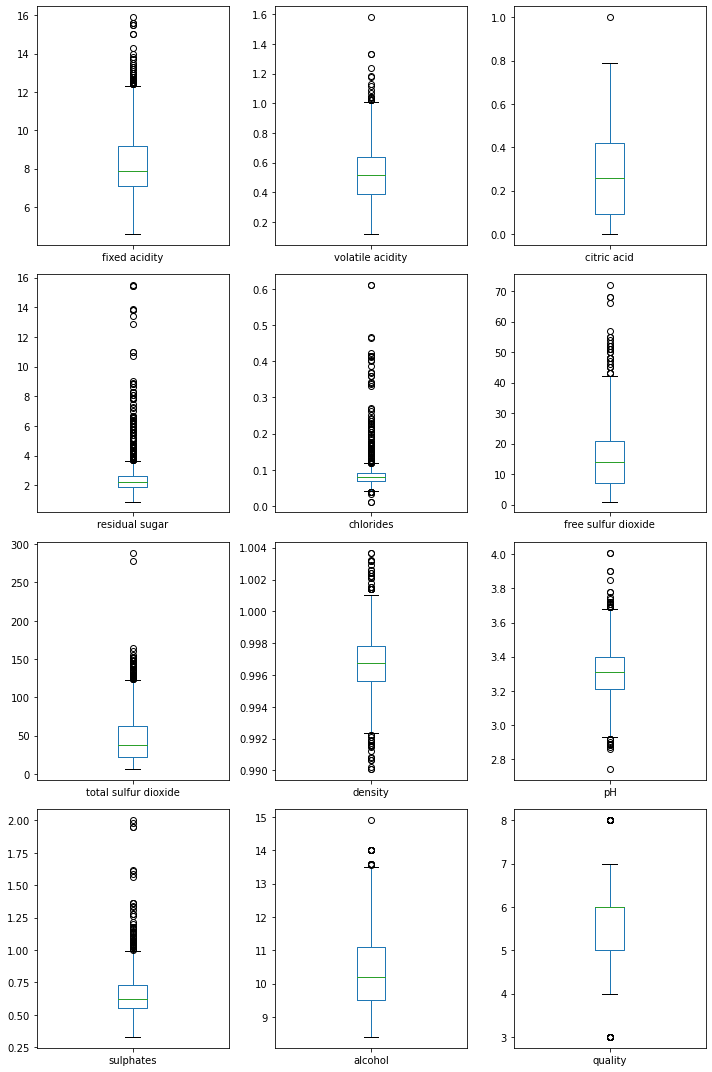

In [86]:
plt.figure(figsize=(10,15))
for i, col in enumerate(list(wine.columns.values)): 
    plt.subplot(4, 3, i+1) 
    wine.boxplot(col) 
    plt.grid() 
    plt.tight_layout()

Almost all the features seem to have outliers. Since there are a lot of outliers dropping them is not the correct way to go. 

### Data Distribution

- pH feature is approximately normally distributed.
- Remaining all independent features are positively skewed.


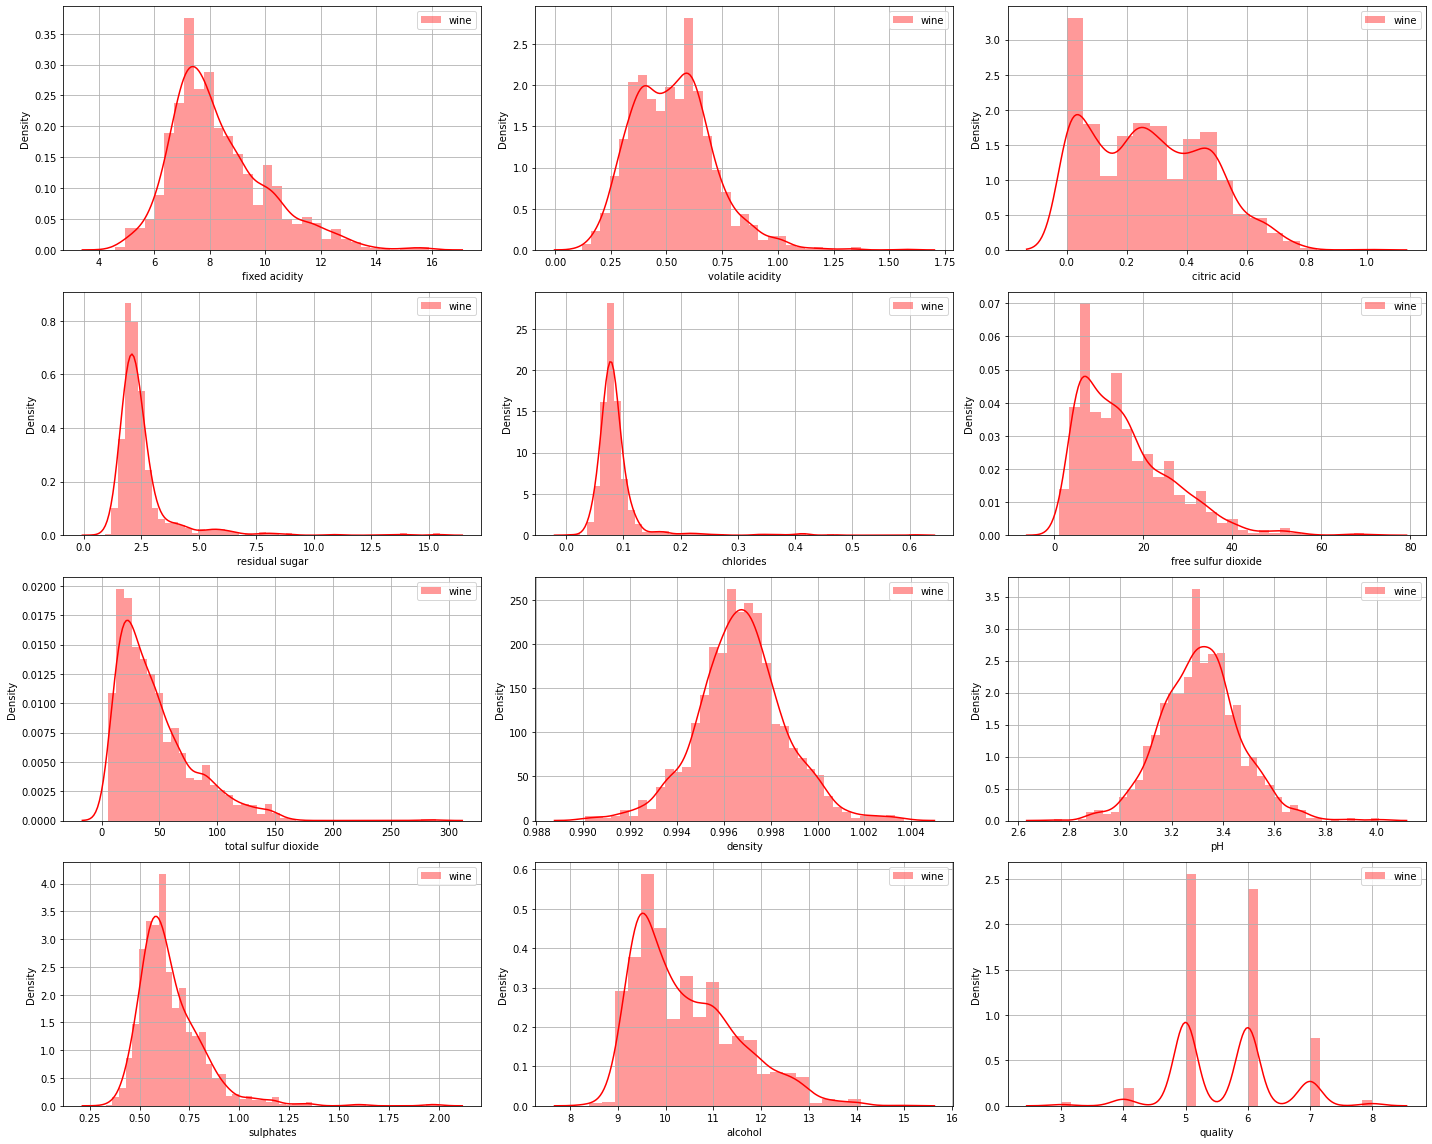

In [87]:
plt.figure(figsize=(20, 16))
for i, col in enumerate(list(wine.columns.values)):
    plt.subplot(4, 3, i+1)
    sns.distplot(wine[col], color='r', kde=True, label='wine')
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()

### Grouped Box Plots

Box plots of each feature with respect to the target variable.

We can see that:
- High quality wines have higher values of Alcohol, Citric Acid, and Sulphates.
- On the contrary, Wines with high volatile acidity, density, and pH are low in quality.
- Wines Quality has no significant relationship with total sulfur dioxide, free sulfur dioxide, chlorides, residual sugar, and fixed acidity.

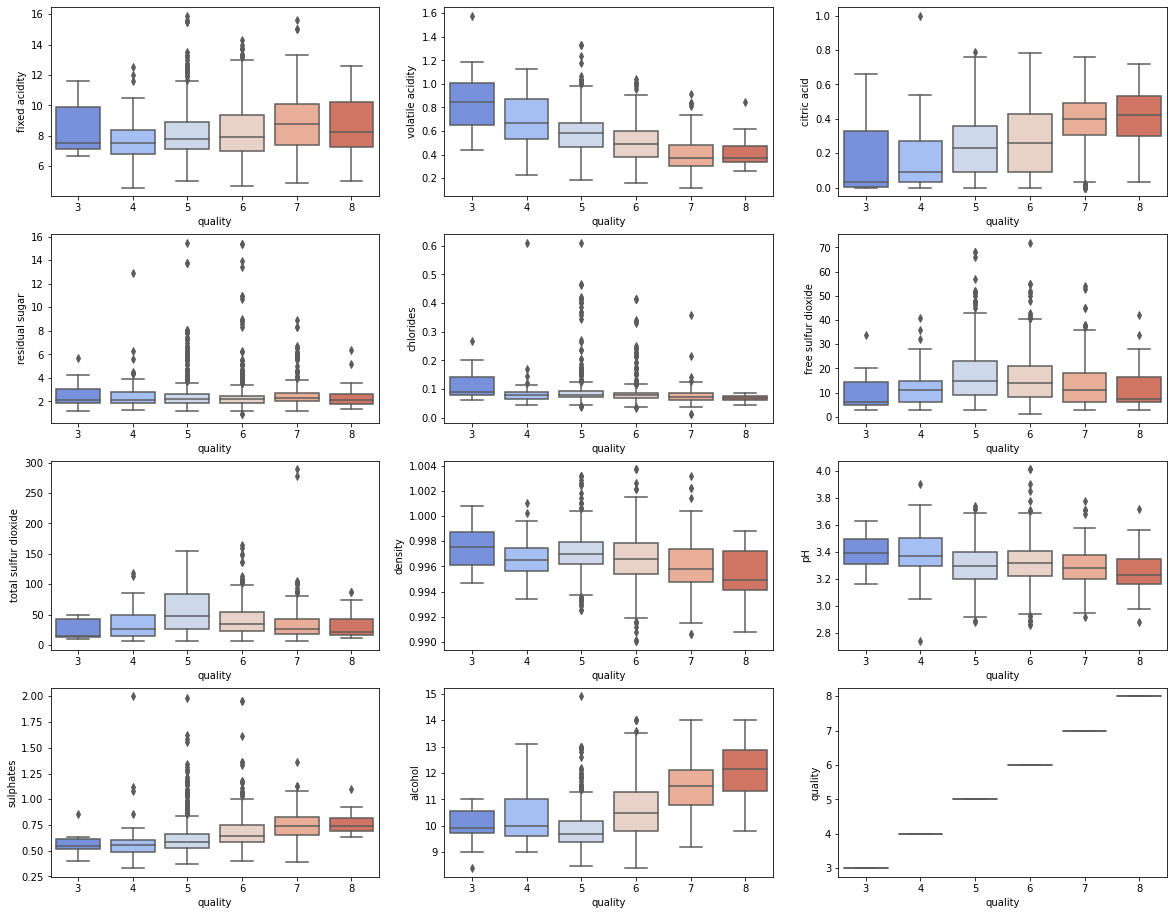

In [88]:
plt.figure(figsize=(20, 16))
cols = wine.columns
cnt = 1
for col in cols:
    plt.subplot(4, 3, cnt)
    sns.boxplot(x="quality", y=col, data=wine, palette="coolwarm")
    cnt += 1
plt.show()

In [89]:
X = wine.drop('quality', axis=1)
y = wine['quality']
print("Shape of X Dataframe: ", X.shape)
print(X.head())
print("")
print("Shape of y Series: ", y.shape)
y.head()

Shape of X Dataframe:  (1599, 11)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  


0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

### Splitting into train and test datasets

We separate the target variable from the feature variables and split the dataset into train and test sets before doing further analysis. We perform preprocesing separately on the train and test datasets to prevent data leakage.

Also, since classes are imbalanced, I have used *stratify* parameter of the `train_test_split` function to preserve the proportions of examples in each class as observed in the original dataset. 

The target variable *quality* is not normally distributed and hence random sampling will lead to an incorrect representation, and thus, incorrect evalution. Usually for continuous target variables, we can create bins for stratifying. Binning isn't needed for this usecase.


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25, stratify=y) 

In [91]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1199, 11)
(1199,)
(400, 11)
(400,)


### Scaling the Data

#### 1. Standardization

Text(0.5, 1.0, 'Histograms - Distribution of Scaled data')

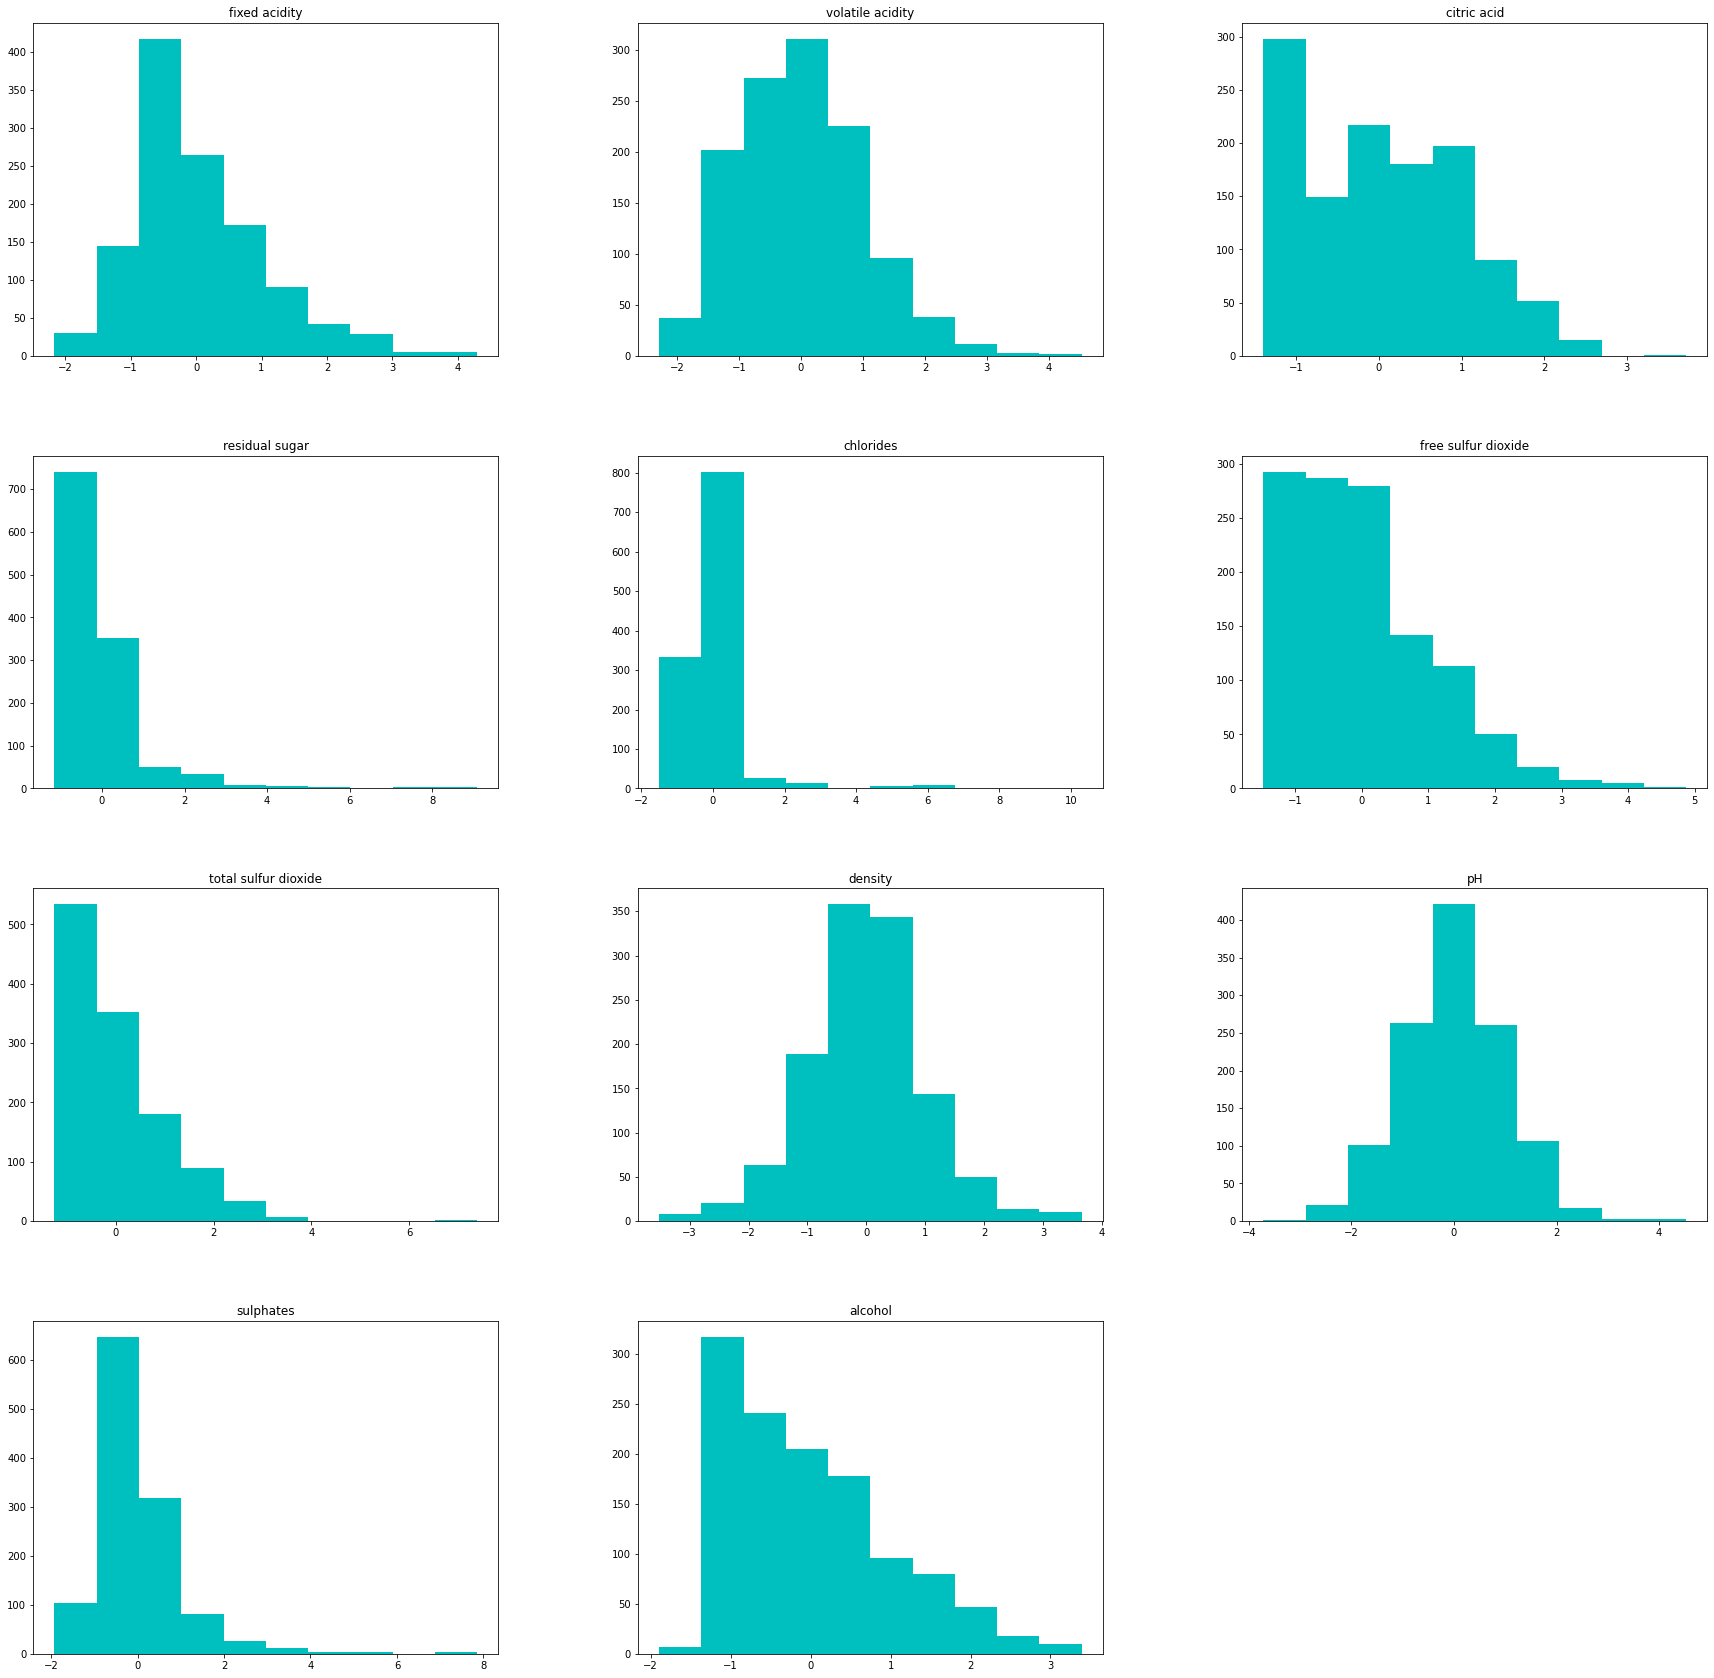

In [92]:
#std-scaling - fit-transform for train and only transform for test
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)
final_tr = pd.DataFrame(data=X_train_std)
final_tr.columns = X_train.columns
final_tr.hist(figsize=(30, 30), color='c', grid=False);
plt.title("Histograms - Distribution of Scaled data")

#### 2. Normalization

Text(0.5, 1.0, 'Histograms - Distribution of Scaled data')

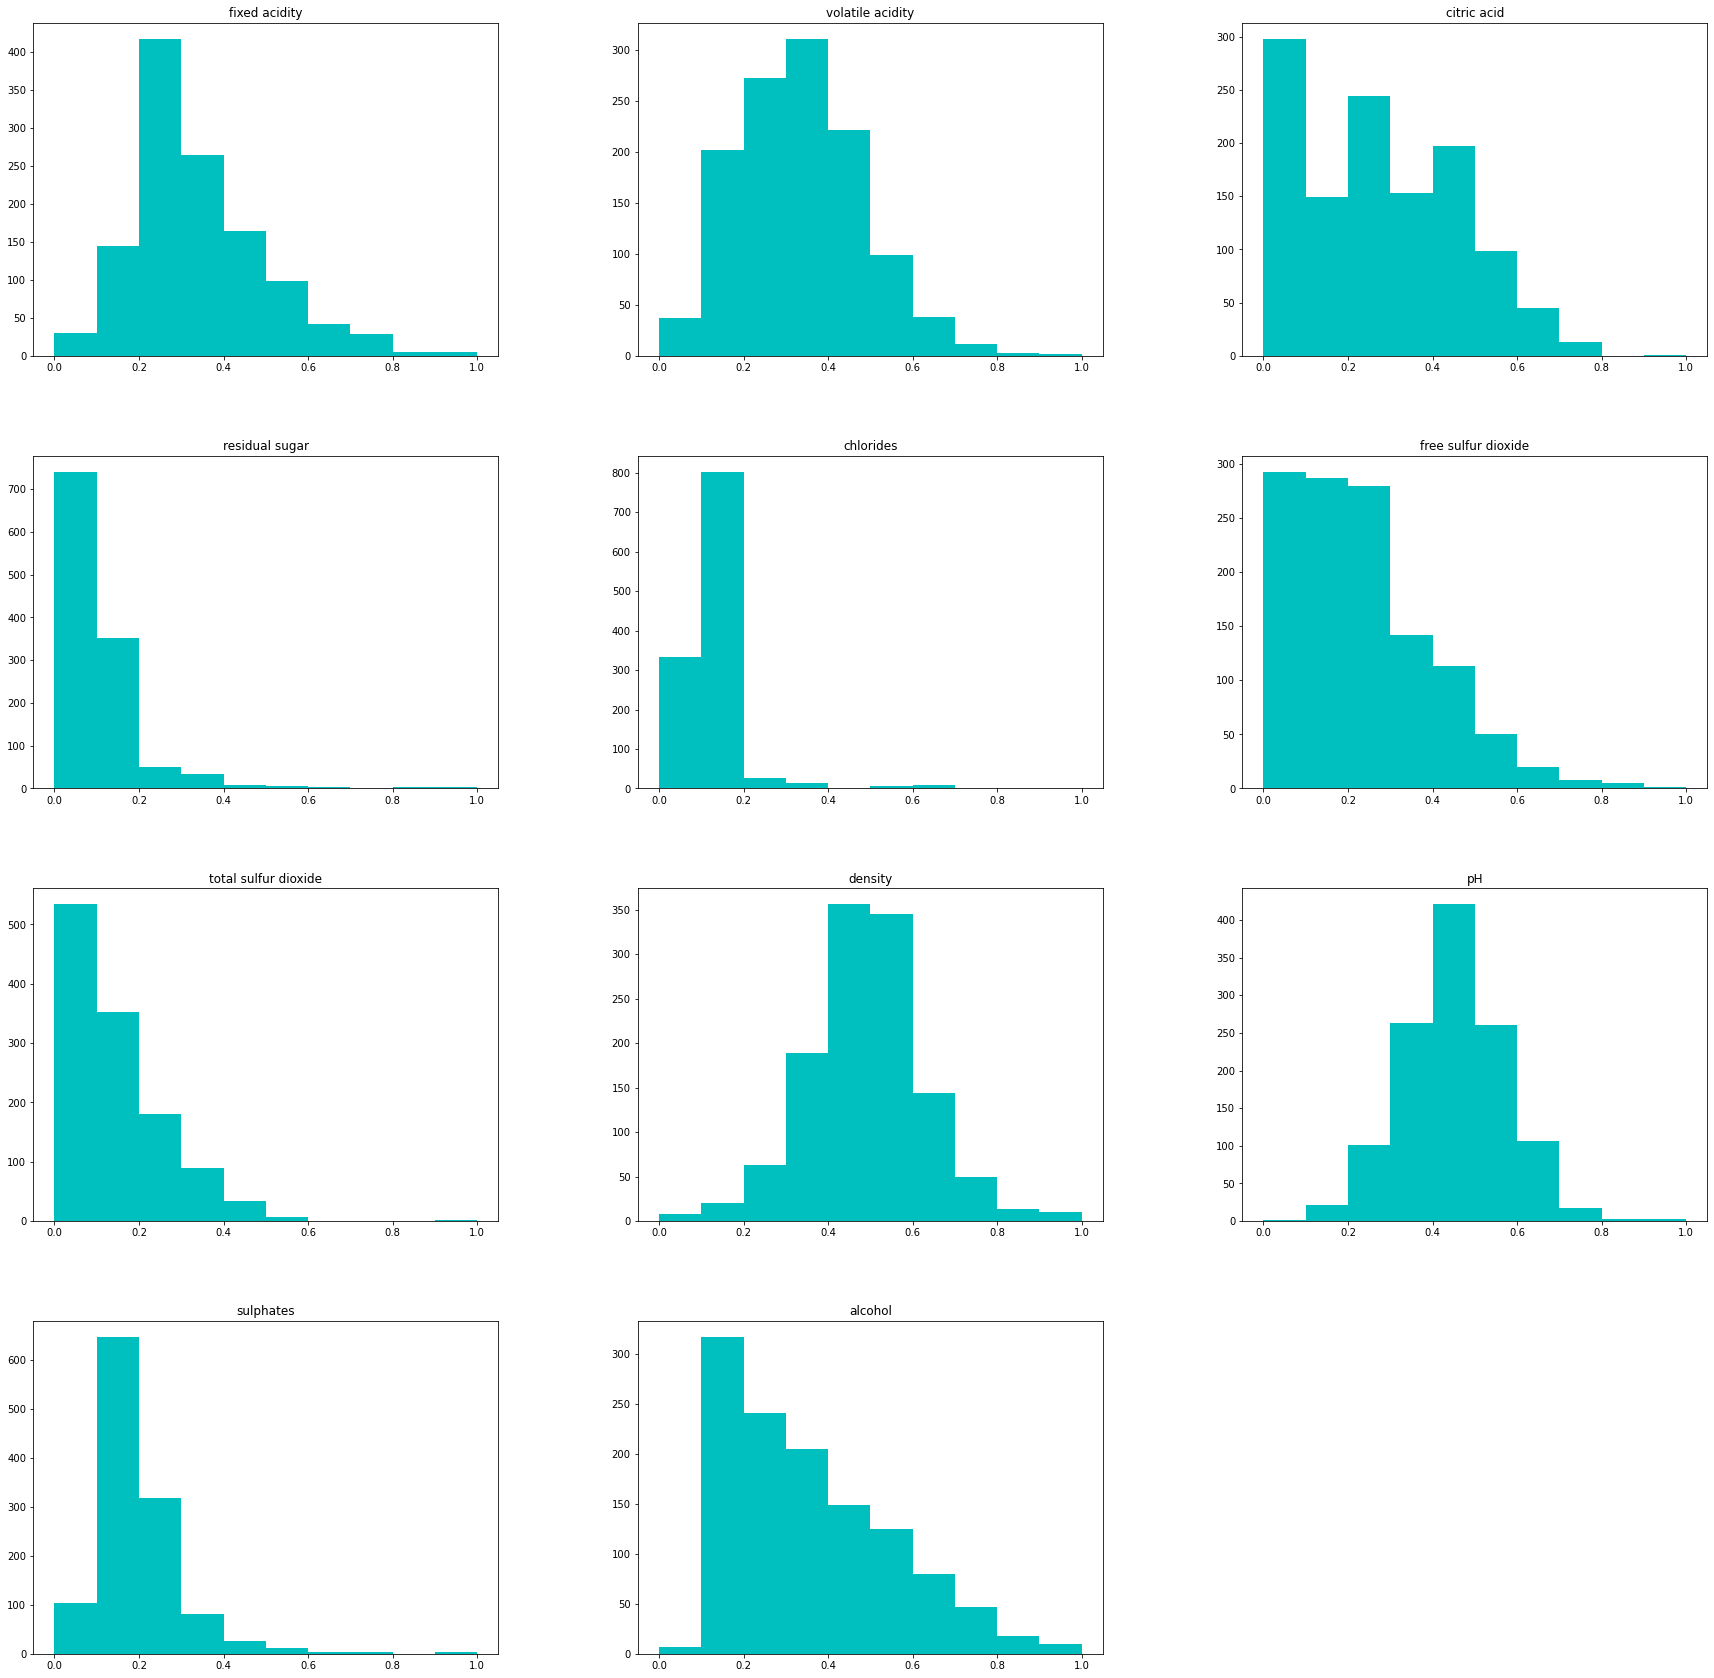

In [93]:
#Min Max Normalization - fit-transform for train and only transform for test
norm_scale = preprocessing.MinMaxScaler().fit(X_train)
X_train_mm = norm_scale.transform(X_train)
X_test_mm = norm_scale.transform(X_test)
final_tr_mm = pd.DataFrame(data=X_train_mm)
final_tr_mm.columns = X_train.columns
final_tr_mm.hist(figsize=(30, 30), color='c', grid=False);
plt.title("Histograms - Distribution of Scaled data")

### Data Transformation

Machine learning algorithms like Linear Regression and Gaussian Naive Bayes assume the numerical variables have a Gaussian probability distribution. Many features of this dataset have a Gaussian-like distribution (i.e. nearly Gaussian but with outliers or a skew)

It is possible to have a better performance on a wide range of machine learning algorithms by transforming input and/or output variables to have a Gaussian or more-Gaussian distribution. Power transforms like the Box-Cox transform and the Yeo-Johnson transform provide an automatic way of performing these transforms on the data and are provided in the scikit-learn Python machine learning library.

In [94]:
pt = PowerTransformer()
X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

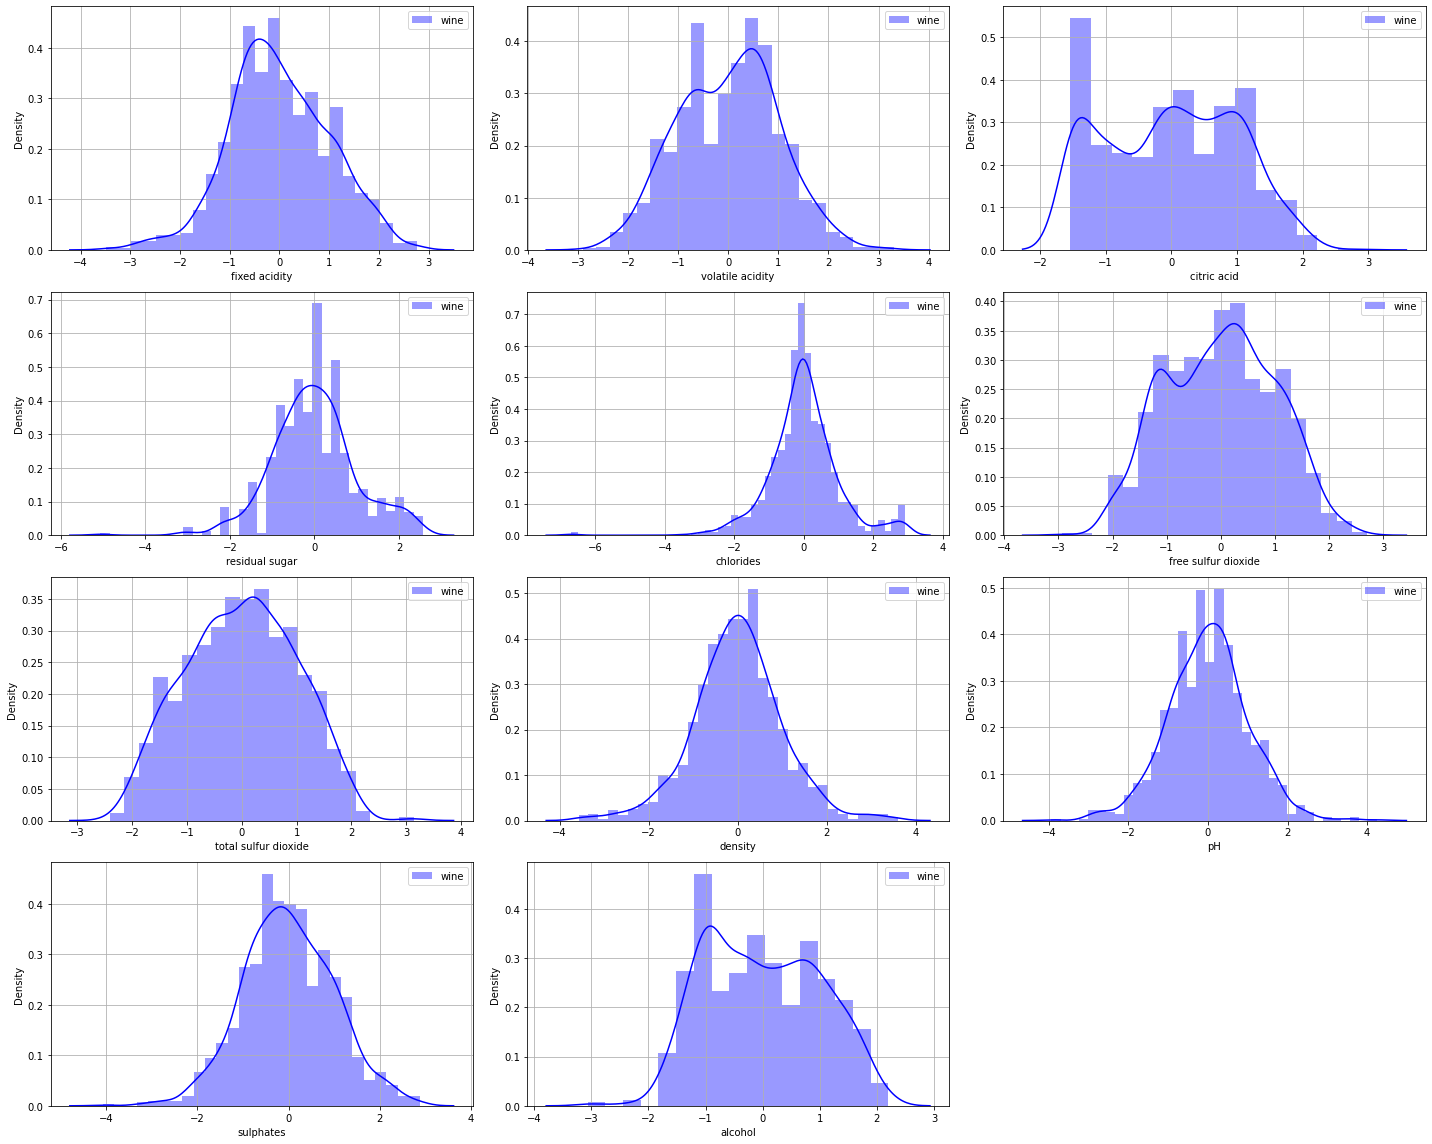

In [95]:
#Testing Distribution
final_df = pd.DataFrame(data=X_train_transformed)
final_df.columns = X_train.columns
plt.figure(figsize=(20, 16)) 
for i, col in enumerate(list (final_df.columns.values)): 
    plt.subplot(4, 3, i+ 1)
    sns.distplot(final_df[col], color='b', kde=True, label='wine') 
    plt.grid() 
    plt.legend(loc='upper right')
    plt.tight_layout()

### Comparision of the 3 methods

#### Outliers after Standardization

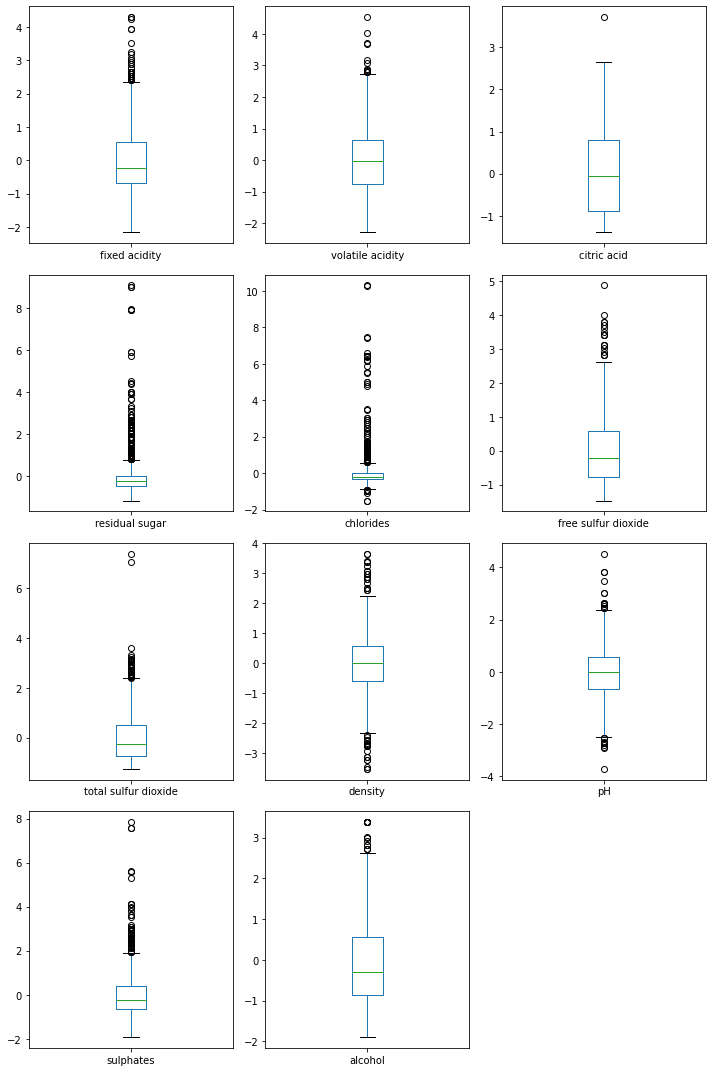

In [96]:
plt.figure(figsize=(10,15))
for i, col in enumerate(list(final_tr.columns.values)): 
    plt.subplot(4, 3, i+1) 
    final_tr.boxplot(col) 
    plt.grid() 
    plt.tight_layout()

#### Outliers after Normalization

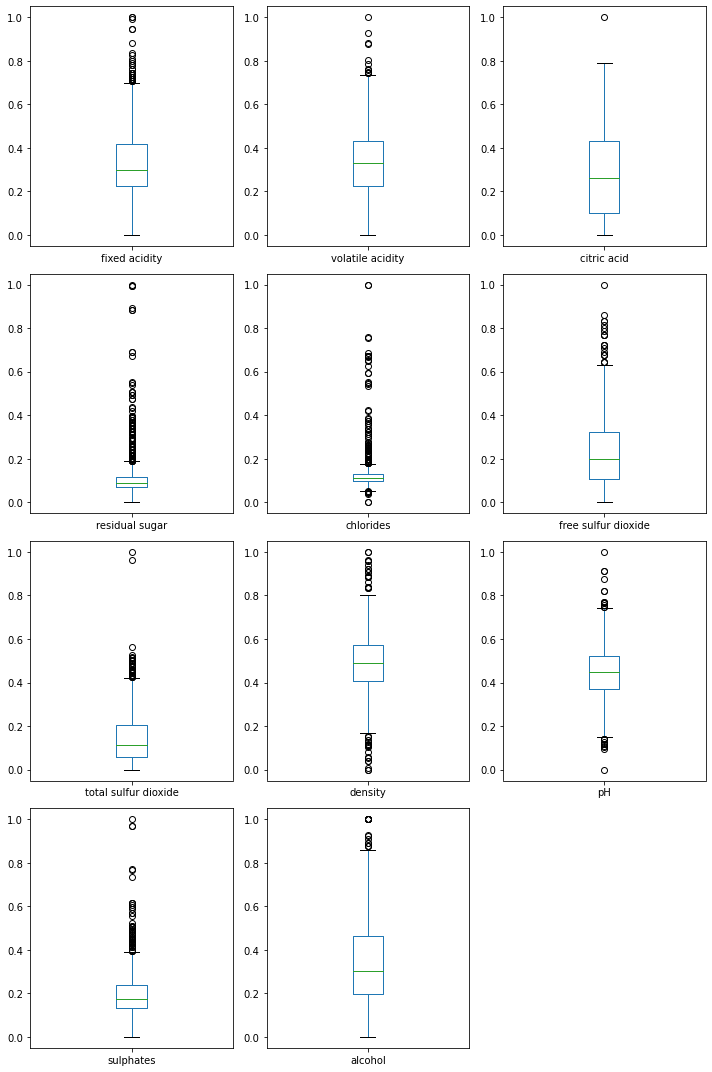

In [97]:
plt.figure(figsize=(10,15))
for i, col in enumerate(list(final_tr_mm.columns.values)): 
    plt.subplot(4, 3, i+1) 
    final_tr_mm.boxplot(col) 
    plt.grid() 
    plt.tight_layout()

#### Outliers after Power Transformation

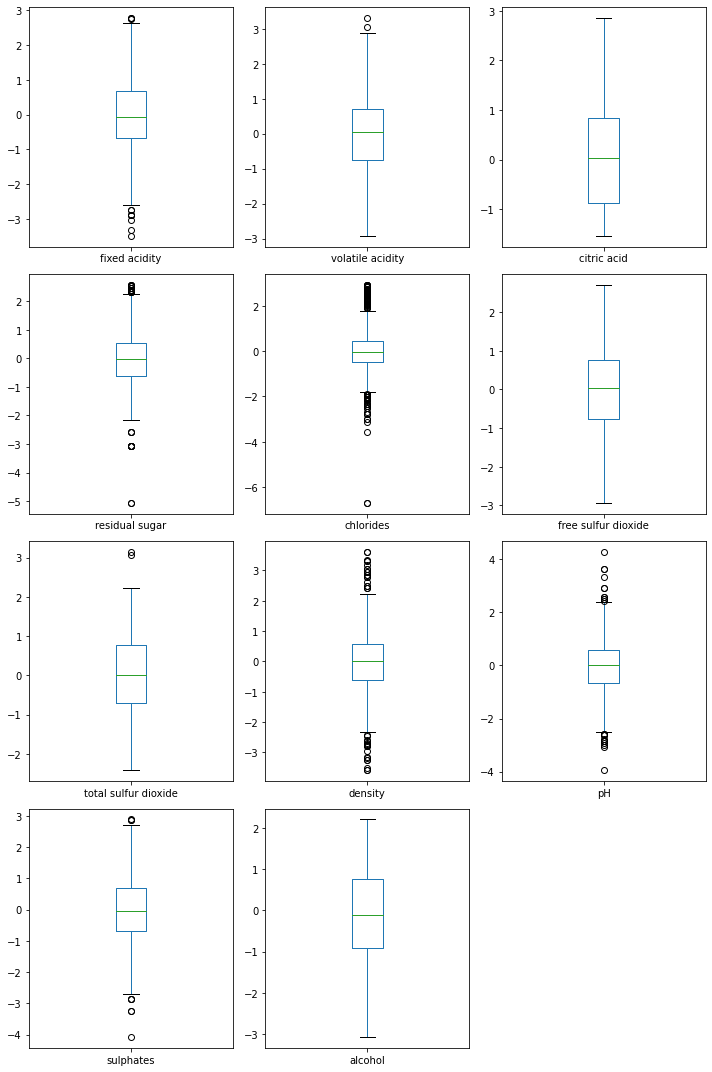

In [98]:
plt.figure(figsize=(10,15))
for i, col in enumerate(list(final_df.columns.values)): 
    plt.subplot(4, 3, i+1) 
    final_df.boxplot(col) 
    plt.grid() 
    plt.tight_layout()

### Inference:
- Normalization can be used to make the scales of data comparable.
- Standardization allows us to use a gaussian distribution.
- Power Transformation takes care of outliers as well as scales the data.

## Modelling

**Models Explored:**
1. Linear Regression
2. kNN Regressor
3. Random Forest Regressor

**Evaluation Metrics Chosen**
- **Mean-squared error (RMSE):** It is a frequently used measure of the differences between values (sample and population values) predicted by a model and the values actually observed. The MSE for training and test sets should be very similar if we have built a good model. If the MSE for the test set is much higher than that of the training set, it is likely that we’ve badly overfit the data.
- **R2:** R2 indicates the amount of variablilty in the target variable defined by the independent variables or features. The higher the R2, the better is the fit.

### Linear Regression 

**1. Without Standardization**

In [21]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)
y_train_pred = reg_model.predict(X_train)

In [22]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.4241731188391569
r2 score:  0.35007961599361936
FOR TEST DATA
mean_squared_error:  0.39927798805235176
r2 score:  0.38475597973365416


**2. With Standardization**

In [23]:
reg_model = LinearRegression()
reg_model.fit(X_train_std, y_train)
y_pred = reg_model.predict(X_test_std)
y_train_pred = reg_model.predict(X_train_std)

In [24]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.42417311883915676
r2 score:  0.3500796159936195
FOR TEST DATA
mean_squared_error:  0.39927798805235104
r2 score:  0.3847559797336553


**3. With Transformation**

In [25]:
reg_model = LinearRegression()
reg_model.fit(X_train_transformed, y_train)
y_pred = reg_model.predict(X_test_transformed)
y_train_pred = reg_model.predict(X_train_transformed)

In [26]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.41882120752304236
r2 score:  0.35827984392710177
FOR TEST DATA
mean_squared_error:  0.3885021378190314
r2 score:  0.40136039474705265


### kNN Regression 
**1. Finding the best parameters**

In [27]:
# Create the parameter grid based on the results of random search 
param_grid = {'n_neighbors':[3,5,15,20,10,30]}
knnmodel = neighbors.KNeighborsRegressor()

grid_search = GridSearchCV(estimator = knnmodel, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 15, 20, 10, 30]}, verbose=1)

In [28]:
grid_search.best_params_

{'n_neighbors': 10}

**2. Without standardization**

In [29]:
knnmodel = neighbors.KNeighborsRegressor(n_neighbors=10)
knnmodel.fit(X_train, y_train)
y_pred = knnmodel.predict(X_test)
y_train_pred = knnmodel.predict(X_train)

In [30]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.4565221017514596
r2 score:  0.300514326580379
FOR TEST DATA
mean_squared_error:  0.55235
r2 score:  0.14888863207365455


**3. With standardization:**

R2 increases after taking standardized data as input.

In [31]:
knnmodel = neighbors.KNeighborsRegressor(n_neighbors=10)
knnmodel.fit(X_train_std, y_train)
y_pred = knnmodel.predict(X_test_std)
y_train_pred = knnmodel.predict(X_train_std)

In [32]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.3692076730608841
r2 score:  0.43429797411367477
FOR TEST DATA
mean_squared_error:  0.42107500000000003
r2 score:  0.35116915135405824


**3. With Transformation**

In [33]:
knnmodel = neighbors.KNeighborsRegressor(n_neighbors=10)
knnmodel.fit(X_train_transformed, y_train)
y_pred = knnmodel.predict(X_test_transformed)
y_train_pred = knnmodel.predict(X_train_transformed)

In [34]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.35314428690575483
r2 score:  0.458910382667417
FOR TEST DATA
mean_squared_error:  0.40887499999999993
r2 score:  0.36996802650333216


*There is no significant improvement after transformation. Hence, I will not be using the transformed data.* 

### Random Forest Regressor - Works the best

Since this works the best, I am going to see the difference of dropping duplicates on this model.

**1. Without dropping duplicates**

In [35]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

In [36]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.05008065054211843
r2 score:  0.9232661519883699
FOR TEST DATA
mean_squared_error:  0.3020565
r2 score:  0.5345637351207673


**2. After Dropping Duplicates**

In [37]:
X_train_d,X_test_d,y_train_d,y_test_d=train_test_split(X,y,random_state=0,test_size=0.25,stratify=y) 

In [38]:
regressor.fit(X_train_d, y_train_d)
y_pred = regressor.predict(X_test_d)
y_train_pred = regressor.predict(X_train_d)

In [39]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.05032869057547957
r2 score:  0.9228861036859877
FOR TEST DATA
mean_squared_error:  0.30570024999999995
r2 score:  0.5289491120613274


**3. With standardization**

Tree based algorithms such as Decision Tree, Random forest and gradient boosting, are not sensitive to the magnitude of variables. So standardization is not needed before fitting this kind of models. 

Verifying the same:

In [40]:
regressor.fit(X_train_std, y_train)
y_pred = regressor.predict(X_test_std)
y_train_pred = regressor.predict(X_train_std)

In [41]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.05095262718932444
r2 score:  0.9219301045770024
FOR TEST DATA
mean_squared_error:  0.3020775
r2 score:  0.534531376401248


**Notes:**
- Since the results are similar, I am going to keep the duplicate entires.
- Also, standardization does not make much difference to this model as mentioned above.

#### Hyperparameter Tuning for Random Forest

In [42]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [43]:
regressor = RandomForestRegressor(bootstrap=False,
                                  max_depth=80,
                                  max_features=2,
                                  min_samples_leaf=3,
                                  min_samples_split=8,
                                  n_estimators=300)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

print("Training")
print("Mean Squared Error: ", mean_squared_error(y_train, y_train_pred))
print("R2 Score: ", r2_score(y_train, y_train_pred))

# For test data
print("Testing")
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Training
Mean Squared Error:  0.07947587289118672
R2 Score:  0.878226630744442
Testing
Mean Squared Error:  0.3071950310264139
R2 Score:  0.5266458168243555


**The errors of training and test data are more comparable here. Hence, this model works better than the above model even if the test accuracy is decreased marginally.**

### XGBoost Regression

In [44]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)

In [45]:
# For training data
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train, y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.0017692087915696063
r2 score:  0.997289208565712
FOR TEST DATA
mean_squared_error:  0.3109547397943703
r2 score:  0.5208525138959585


#### Hyper parameter tuning for xgboost

In [46]:
hyperparameter_grid = {
    'n_estimators': [100,200, 400, 500],
    'max_depth': [3, 6, 5, 9],
    'learning_rate': [0.05, 0.1, 0.20, 0.001],
    'min_child_weight': [1, 10, 100]
    }

In [47]:
grid_search = GridSearchCV(estimator = xgb, param_grid = hyperparameter_grid, 
                          cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat...ep=0,
                                    max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=0,
                                    reg_alpha=0, reg_lambda=1, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.001],
                         'max_depth': [3, 6, 5, 9],
                         'min_child_weight': [1, 10, 100],
                         'n_estimators': [100, 200, 400, 500]},
             verbose=1)

In [48]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 200}

#### Building final model

In [49]:
xgb_tuned = xgboost.XGBRegressor(learning_rate=0.05,
                                 max_depth= 9, 
                                 min_child_weight= 1,
                                 n_estimators=200)
xgb_tuned.fit(X_train, y_train)

y_pred = xgb_tuned.predict(X_test)
y_train_pred = xgb_tuned.predict(X_train)
# For training data - without stratify
print("\033[1mFOR TRAIN DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_train, y_train_pred))
print("r2 score: ", r2_score(y_train,y_train_pred))

# For test data
print("\033[1mFOR TEST DATA\033[0m")
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

FOR TRAIN DATA
mean_squared_error:  0.004595625235276676
r2 score:  0.9929585577562424
FOR TEST DATA
mean_squared_error:  0.30292876379771727
r2 score:  0.5332196713313806


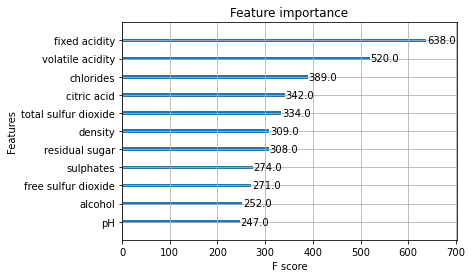

In [50]:
plot_importance(xgb)
pyplot.show()

All the features seem to have significant level of importance while making a prediction. Hence, I will not be dropping any features.

### Using Neural Network

There are 3 typical steps to creating a model in TensorFlow:

- **Creating a model** –Create a neural network by using Sequential or Functional API, or, import a previously built model (transfer learning)
- **Compiling a model** – Measure the model's performance and pick optimizers
- **Fitting a model** – Introduce the model to the data and let it find patterns

#### 1. Trying Basic Keras Model - Without Pipeline

In [51]:
#Define Features
n_features = X.shape[1]

In [52]:
# Defining function to plot a loss curve

def plot_performance(hist):
    mse = hist.history['loss']
    val_mse = hist.history['val_loss']
    epochs = range(len(mse))
    plt.plot(epochs, mse, 'r', label='Training Loss')
    plt.plot(epochs, val_mse, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


**Creating and Compiling the Model**

In [53]:
# setting seed for replicating output

tf.random.set_seed(42)

# Defining a function for creating a model


def def_model(optimizer=keras.optimizers.Adam(learning_rate=0.01)):
    model = Sequential()
    # Adding Layers
    model.add(Dense(128, activation='relu', input_shape=(n_features,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model

**A Note on Early Stopping:**

- Keras supports the early stopping of training via a callback called EarlyStopping.
- This callback allows you to specify:
    - The performance measure to monitor using the argument *monitor*
    - The trigger to stop the training process using the argument *mode*
    - A delay to the trigger in terms of the number of epochs on which we would like to see no improvement by argument *patience*
- It can be used while fitting the model via the *callbacks* argument
- Early stopping will not always lead to an optimal performance but it can be lot quicker and also help in reducing overfitting

Here, as soon as the loss of the model begins to increase on the test dataset, I will wait for about a 100 epochs and then stop training to prevent the model from overfitting.

In [54]:
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=200, verbose=1)

# Setting variables
EPOCHS = 2000
BATCHES = 10

# Building Model
model = def_model()

2022-05-28 18:36:42.017662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-28 18:36:42.017842: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-28 18:36:42.017888: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a21f8c1a9e3b): /proc/driver/nvidia/version does not exist
2022-05-28 18:36:42.019083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
history = model.fit(X_train_std, y_train,
                    epochs=EPOCHS, validation_split=0.2, 
                    batch_size=BATCHES, verbose=1,
                    callbacks=[es])

Epoch 1/2000
96/96 [==============================] - 1s 5ms/step - loss: 3.7136 - val_loss: 1.1265
Epoch 2/2000
96/96 [==============================] - 0s 4ms/step - loss: 1.1048 - val_loss: 0.6645
Epoch 3/2000
96/96 [==============================] - 0s 4ms/step - loss: 0.7172 - val_loss: 0.4960
Epoch 4/2000
96/96 [==============================] - 0s 4ms/step - loss: 0.6302 - val_loss: 0.4524
Epoch 5/2000
96/96 [==============================] - 0s 4ms/step - loss: 0.5675 - val_loss: 0.4869
Epoch 6/2000
96/96 [==============================] - 0s 3ms/step - loss: 0.5063 - val_loss: 0.4789
Epoch 7/2000
96/96 [==============================] - 0s 3ms/step - loss: 0.5216 - val_loss: 0.5022
Epoch 8/2000
96/96 [==============================] - 0s 4ms/step - loss: 0.4747 - val_loss: 0.4465
Epoch 9/2000
96/96 [==============================] - 1s 5ms/step - loss: 0.5028 - val_loss: 0.4849
Epoch 10/2000
96/96 [==============================] - 1s 6ms/step - loss: 0.4294 - val_loss: 0.4205

**Evaluating the Model**

In [56]:
model.evaluate(X_test_std, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.4168


0.41676148772239685

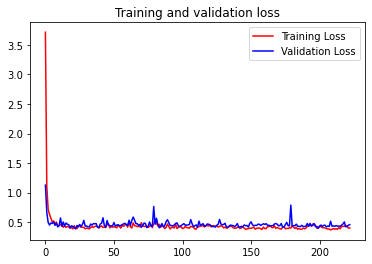

In [57]:
plot_performance(history)

**Inference:**
- We can see that the training loss decreases steeply at first and then gradually as the epochs progresses. This shows that the model is learning patterns from the data and is clearly not underfitting. 
- The loss on test data also decreases along with the training loss and the curves converge. This shows that the model has not learnt the noise in the training data and is performing equivalent on the test data. There is no overfitting. 

In [58]:
def test_model(model=model):
    wine_sample_number =  input("Enter sample number of the wine you wish to test the model on (0 to 400): ")
    try:
        wine_sample_number = int(wine_sample_number)
        if(-1<wine_sample_number<401):
            print('The original quality score is: ', y_test.iloc[wine_sample_number])
            y_pred = model.predict(X_test)
            print('The predicted quality score is: ', float(y_pred[wine_sample_number]))
        else:
            print("Incorrect Input!")
    except ValueError:
        print("Valid number, please")
        

In [59]:
test_model(model)

Enter sample number of the wine you wish to test the model on (0 to 400):  4


The original quality score is:  6
13/13 [==============================] - 0s 2ms/step
The predicted quality score is:  5.448686599731445


In [60]:
test_model()

Enter sample number of the wine you wish to test the model on (0 to 400):  4.4


Valid number, please


In [61]:
test_model()

Enter sample number of the wine you wish to test the model on (0 to 400):  600


Incorrect Input!


#### 2. Keras Regressor and Using Pipeline for Neural Networks

We can create Keras models and evaluate them with scikit-learn by using handy wrapper objects provided by the Keras library. This is desirable, because scikit-learn excels at evaluating models and will allow us to use powerful data preparation and model evaluation schemes with very few lines of code.

##### Using Pipeline 

Scikit-learn’s Pipeline is a major productivity tool to facilitate cleaning up code and collapsing all preprocessing and modeling steps into to a single line of code.

Note: Since XGBoost and RandomForest do not need features to be standardized, I did not include a pipeline before.

In [62]:
# Re-Defining the Model Function For Experimenting with more parameters


# Setting seed for replicating output
tf.random.set_seed(50)  

# Defining a function for creating a model

# I have used glorot_uniform since it is the default value for kernel_initializer of Dense Layer


def def_model(optimizer=keras.optimizers.Adam(learning_rate=0.01), init='glorot_uniform'):
    model = Sequential() 
    # Adding Layers
    model.add(Dense(128, activation='relu',  kernel_initializer=init, input_shape=(n_features,))) 
    model.add(Dropout(0.2))
    model.add(Dense(64,  kernel_initializer=init,activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,  kernel_initializer=init,activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mse', optimizer=optimizer)
    return model


In [63]:
nn_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing.StandardScaler()),
    ('model', KerasRegressor(build_fn=def_model, nb_epoch=500,
                             batch_size=10, verbose=False))
])

kfold = KFold(n_splits=4)
results = cross_val_score(nn_pipeline, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -1.07 (0.28) MSE


In [64]:
nn_pipeline.fit(X_train, y_train)
prediction = nn_pipeline.predict(X_test)

In [65]:
prediction[3]

5.581373

In [66]:
y_test.iloc[3]

6

##### Hyperparameter Tuning 

In [67]:
param_grid = {
    'model__optimizer': ['rmsprop', 'adam', 'adagrad'],
    'model__init': ['he_normal', 'glorot_uniform', 'normal', 'uniform']}
grid = GridSearchCV(nn_pipeline, cv=3,
                    param_grid=param_grid, scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess', StandardScaler()),
                                       ('model',
                                        <keras.wrappers.scikit_learn.KerasRegressor object at 0x7fce5747d0a0>)]),
             param_grid={'model__init': ['he_normal', 'glorot_uniform',
                                         'normal', 'uniform'],
                         'model__optimizer': ['rmsprop', 'adam', 'adagrad']},
             scoring='neg_mean_squared_error')

In [68]:
#summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: -1.393922 using {'model__init': 'uniform', 'model__optimizer': 'rmsprop'}

-2.725845 (0.347790) with: {'model__init': 'he_normal', 'model__optimizer': 'rmsprop'}
-3.119313 (0.344465) with: {'model__init': 'he_normal', 'model__optimizer': 'adam'}
-6.392292 (0.531615) with: {'model__init': 'he_normal', 'model__optimizer': 'adagrad'}
-1.959483 (0.237617) with: {'model__init': 'glorot_uniform', 'model__optimizer': 'rmsprop'}
-2.157439 (0.190704) with: {'model__init': 'glorot_uniform', 'model__optimizer': 'adam'}
-13.794529 (4.061095) with: {'model__init': 'glorot_uniform', 'model__optimizer': 'adagrad'}
-1.587047 (0.237858) with: {'model__init': 'normal', 'model__optimizer': 'rmsprop'}
-1.776884 (0.217473) with: {'model__init': 'normal', 'model__optimizer': 'adam'}
-31.999164 (0.562407) with: {'model__init': 'normal', 'model__optimizer': 'adagrad'}
-1.393922 (0.165557) with: {'model__init': 'uniform', 'model__optimizer': 'rmsprop'}
-1.600620 (0.149411) with: {'model__init': 'uniform'

**Testing the model obtained by grid search**

In [69]:
tf.random.set_seed(50)

def def_model(optimizer="rmsprop", init='uniform'):
    model = Sequential() 
    # Adding Layers
    model.add(Dense(128, activation='relu',  kernel_initializer=init, input_shape=(n_features,))) 
    model.add(Dropout(0.2))
    model.add(Dense(64,  kernel_initializer=init,activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,  kernel_initializer=init,activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mse', optimizer=optimizer) 
    return model


In [70]:
# Building the model
nn_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing.StandardScaler()),
    ('model', KerasRegressor(build_fn=def_model, nb_epoch=500,
                             batch_size=10, verbose=False))
])

# Fitting the model 
nn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', StandardScaler()),
                ('model',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7fce5c109f10>)])

In [71]:
test_model(model=nn_pipeline)

Enter sample number of the wine you wish to test the model on (0 to 400):  398


The original quality score is:  6
The predicted quality score is:  6.319284439086914


## Comparing Predictions

#### Random Forest

In [72]:
test_model(model=regressor)

Enter sample number of the wine you wish to test the model on (0 to 400):  398


The original quality score is:  6
The predicted quality score is:  6.0191984126984135


#### XGBoost

In [73]:
test_model(model=xgb_tuned)

Enter sample number of the wine you wish to test the model on (0 to 400):  398


The original quality score is:  6
The predicted quality score is:  5.999758720397949


#### Neural Network

In [74]:
test_model(model=nn_pipeline)

Enter sample number of the wine you wish to test the model on (0 to 400):  398


The original quality score is:  6
The predicted quality score is:  6.319284439086914


## Conclusion: 

- The red wine quality was predicted using 3 approaches: Sk-learn basic regressors, XGBoost and Neural Networks.
- Preprocessing the data did not change the accuracy of prediction by a lot and hence original data was used for analysis. However, for algorithms sensitive to scale of data, standardization was implemented.
- Hyperparameter tuning was done to get the optimal results after implementing pipelines for cleaner code.
- The error metric of MSE and r2 was used to determine model accuracy and compare the results
- The XGBoost and Random Forest regressor show comparable performance with MSE being 0.30 for the test dataset. However, both the models have a very low training MSE. 
- The neural network model has a similar performance on training and test dataset.